# 如何构建更好的模型

| ![](../../_static/logo/megvii-32.svg) [在 MegStudio 运行](https://studio.brainpp.com/project/#) | ![](../../_static/logo/github-32.svg) [查看源文件](https://github.com/MegEngine/Documentation/blob/main/source/getting-started/beginner/from-linear-regression-to-linear-classification.ipynb) |
| --- | --- |

我们已经对机器学习的基础流程有了一定的印象，并尝试用线性模型分别在 “新手级别” 的房价回归和手写数字分类任务上取得了不错的效果。

打怪升级的道路还在继续，我们的任务依旧是图像分类，但本次教程较之前又确实有所不同：

- 我们将回收上一个教程埋下的伏笔，了解另一个计算机视觉领域的经典数据集 CIFAR10, 一起看看数据特征的变化会带来什么样的挑战；
- 我们还将开动脑筋，分析已有局面，尝试去构建更好的模型——
- 思路一是改变模型的结构，这意味着我们要认知到线性模型在结构上的局限性；
- 思路二是改变特征提取的方式，此时我们更多地要从数据的角度去思考，看看传统计算机视觉方法带来了什么样的启发。

不知不觉见，我们已经将半只脚踏入深度学习领域了。

请先运行下面的代码，检验你的环境中是否已经安装好 MegEngine（[访问官网安装教程](https://megengine.org.cn/install)）：

In [1]:
import megengine

print(megengine.__version__)

1.4.0


接下来，我们将先了解一下这次要使用到的经典数据集：[CIFAR-10 数据集](https://www.cs.toronto.edu/~kriz/cifar.html)。

## CIFAR-10 数据集

CIFAR-10 数据集包含共计 10 个类别的 60000 张 32x32 彩色图像，每个类别包含 6000 个图像，对应有 50000 张训练图像和 10000 张测试图像。

同样地，在 MegEngine 的 dataset 模块中内置了 CIFAR-10 数据集的相关接口，方便初学者进行相关调用：

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from megengine.data.dataset import CIFAR10

# 强烈推荐使用 MegStudio 平台，可在项目设置中直接选用 CIFAR10 数据集，无需再进行下载
# 如果使用 MegStudio 环境，请将 MNIST_DATA_PATH 为 /home/megstudio/dataset/MNIST/
CIFAR10_DATA_PATH = "/data/datasets/CIFAR10/"

# 国内网络环境从 CIFAR10 数据集官方主页下载数据集可能会有些慢，可人为下载好以下文件后，放置在 CIFAR10_DATA_PATH 对应的路径
#     cifar-10-python.tar.gz
#     cifar-10-batches-py/
#       batches.meta  
#       data_batch_1  
#       data_batch_2  
#       data_batch_3  
#       data_batch_4  
#       data_batch_5  
#       readme.html  
#       test_batch

# 获取训练数据集，如果本地没有数据集，请将 download 参数设置为 True
train_dataset = CIFAR10(root=CIFAR10_DATA_PATH, train=True, download=False)
print(train_dataset.meta)
print(len(train_dataset), type(train_dataset[0]))
print(len(train_dataset[0]), train_dataset[0][0].shape, train_dataset[0][1].shape)

{b'num_cases_per_batch': 10000, b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], b'num_vis': 3072}
50000 <class 'tuple'>
2 (32, 32, 3) ()


以训练集为例，你最终将得到一个长度为 50000 的 `train_dataset` 列表，其中的每个元素是一个包含样本和标签的元组：

In [3]:
print(train_dataset.meta)
print(len(train_dataset), type(train_dataset[0]))
print(len(train_dataset[0]), train_dataset[0][0].shape, train_dataset[0][1].shape)

{b'num_cases_per_batch': 10000, b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], b'num_vis': 3072}
50000 <class 'tuple'>
2 (32, 32, 3) ()


为了方便理解，我们这里选择将数据集拆分为样本和标签，处理成 Numpy 的 ndarray 格式：

In [4]:
train_data = np.array([t[0] for t in train_dataset])
train_label = np.array([t[1] for t in train_dataset])
print(train_data.shape, train_label.shape)

(50000, 32, 32, 3) (50000,)


经过上面的整理，我们得到了训练数据 `train_data` 和对应的标签 `train_label`:

- 可以发现此时的训练数据的形状是 $(50000, 32, 32, 3)$, 分别对应数据量（Number）、高度（Height）、宽度（Width）和通道数（Channel），简记为 NHWC；
- 你应该发现了，MNIST 数据集中的通道数为 1, 均为黑白图；而 CIFAR-10 数据集的通道数为 3, 数据集中的图像是彩色的；通道数和颜色之间有什么关系呢？

### 理解彩色图像数据

我们先尝试对数据进行随机抽样，并进行可视化显示：

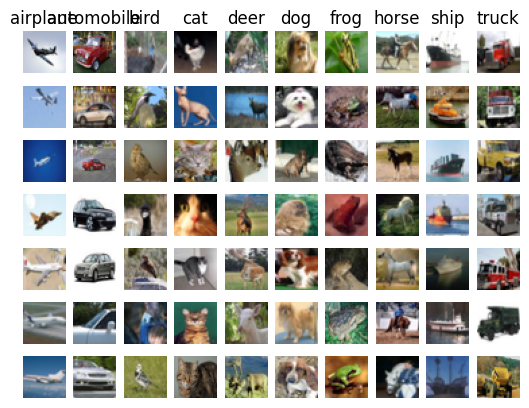

In [5]:
import cv2   # 我们后面会提到 cvtColor 方法，因此要用到 cv2 库（OpenCV）

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 
num_classes = len(classes)
samples_per_class = 7

# 注意：初学者在接触本小节的可视化代码时可不求甚解，只在意其展示效果并阅读后面的部分，学有余力者可尝试搞清楚代码细节。
for y, cls in enumerate(classes):
    idxs = np.squeeze(np.where(train_label == y))
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(cv2.cvtColor(train_data[idx], cv2.COLOR_BGR2RGB))  # 注意：这里我们已经使用 cvtColor 对图像进行了处理
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

挑选出一张图片（下方的 idx 可修改），进行可视化：

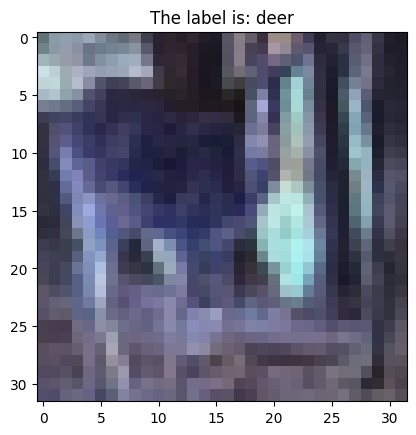

In [6]:
idx = 10086 # 可以修改这个值
plt.title("The label is: %s" % classes[train_label[idx]])
plt.imshow(train_data[idx])
plt.show()

你是否会觉得有一些奇怪，为什么这张图片的颜色给人感觉有些奇怪呢？

- 出于历史原因， OpenCV(cv2) 图像库默认使用 BGR 的颜色通道，而不是一般约定的 RGB 格式。
- 这就导致当 `plt.imgshow()` 尝试以 RGB 顺序去读取一张 BGR 格式的图片时，显示的内容会不如预期。
- 好在 `cv2` 中也提供了 `cvtColor` 功能，能够改变图像的通道排序。

如果你使用过老前辈级别的深度学习框架 [Caffe](https://caffe.berkeleyvision.org/), 应该会对此颇有感触。在 MegEngine 的 `funtional.vision` 模块中也实现了 `cvt_color`, 区别在于要求输入的数据类型是 Tensor, 毕竟 MegEngine 不是计算机视觉库，`funtional` 模块中的接口是为 Tensor 操作而设计的。

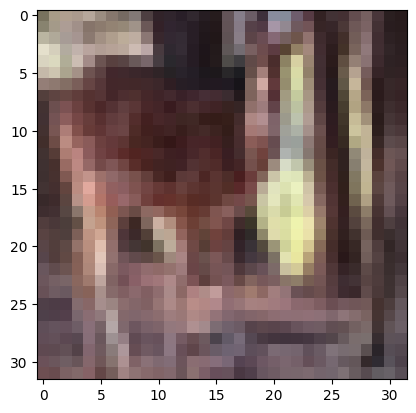

In [7]:
ori_image = train_data[idx]
cvt_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)
plt.imshow(cvt_image)
plt.show()

我们可以分别对三个颜色通道进行可视化（下面的代码看不懂也没关系，看图）：

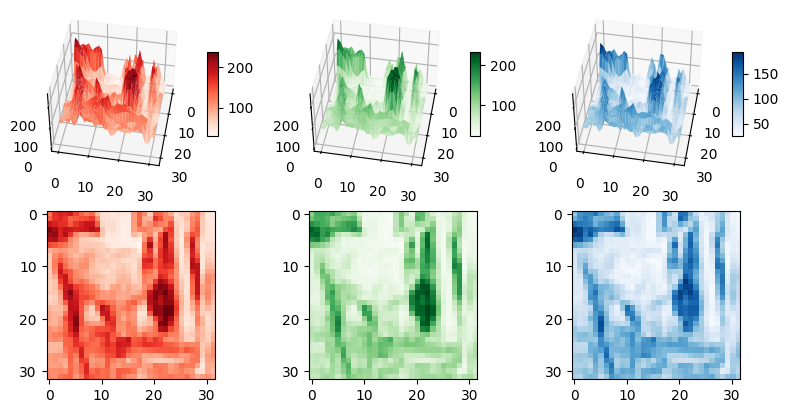

In [8]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

split_image = cv2.split(cvt_image)  # 划分为 [R, G, B]
color_maps = ['Reds', 'Greens', 'Blues']

fig = plt.figure(figsize=plt.figaspect(0.5))

for channel_idx, color in enumerate(color_maps):
    ax = fig.add_subplot(2, 3, channel_idx+1, projection='3d')
    ax.set_zlim(-10, 255)
    ax.view_init(elev=45, azim=10)
    X, Y = np.meshgrid(np.arange(32), np.arange(32))
    Z = np.squeeze(split_image[channel_idx])
    surf = ax.plot_surface(Y, X, Z, cmap=color)
    plt.colorbar(surf, shrink=0.5, aspect=8)
    
    plt.subplot(2, 3, channel_idx+4)
    plt.imshow(split_image[channel_idx], cmap=color)

plt.show()

数字图像基础和背后的历史知识可有趣啦，一时半会儿也讲不完。在这次的教程中，我们目前只需要明白：

- 可见光谱中的大部分颜色可以由三种基本色光按不同的比例混合而成，这三种基本色光的颜色就是红、绿、 蓝三原色光。
- 这意味着相较于灰度图，RGB 图中的每个像素都是由 $3$ 个在 $[0, 256)$ 的值进行颜色组合表示的，对应十六进制范围 `#000000` ~ `#FFFFFFF`.

不妨先自己想一想，这样的数据给我们带来了什么样的挑战？线性模型存在着什么样的局限性，我们又该如何去解决它们。

## 更复杂的计算图结构

我们曾经学习过计算图的概念，提到 **任何一个神经网络结构都可以用计算图来表示，** 而整个网络中应该有非常多的节点（神经元）：

- 已知：将单个样本的特征向量 $\mathbf {x}$ 与权重向量 $\mathbf {w}$ 相乘并且加上一个偏置 $b$， 得到了一个预测值 $\hat{y}$ ;
- 如果希望某一层能同时得到多个输出，就需要与权重矩阵 $W$ 相乘并加上偏置（如果这是输出层，输出的就是最终的预测值，后接 Softmax 分类器）；
- 假设我们现在希望有一个更多层的网络结构——在不做任何处理的情况下，每一层的输入都会是上一层线性函数的输出 ;

这样简单堆叠的话，将导致网络最终的输出依旧是输入特征值的线性组合，我们用代码解释一下：

In [9]:
np.random.seed(20200325)
x = np.random.random((28 * 28)) # 随机生成一个 28x 28 “图像“，展平成列向量

W1 = np.random.random((16, 28 * 28))
b1 = np.random.random((16))
W2 = np.random.random((10, 16))
b2 = np.random.random((10))

def twoLayer(inp):
    z1 = np.dot(W1, inp) + b1
    z2 = np.dot(W2, z1) + b2
    return z2

def oneLayer(inp):
    w = np.dot(W2, W1)
    b = np.dot(W2, b1) + b2
    z = np.dot(w, inp) + b
    return z

print(twoLayer(x))
print(oneLayer(x))

[1778.1240227  1686.58678634 1696.10346373 1683.52540592 1460.30539558
 1824.70144725 1607.90706718 1910.38439594 1766.86194029 1801.54371206]
[1778.1240227  1686.58678634 1696.10346373 1683.52540592 1460.30539558
 1824.70144725 1607.90706718 1910.38439594 1766.86194029 1801.54371206]


上面的例子展示了：在假定模型参数已经训练收敛的情况下，单层的线性模型和双层的线性模型有着一样的预测效果（显然，更多层也一样）。

- 对于双层模型，$\hat{y} = W2 \cdot (W1 \cdot \mathbf{x} + b1) + b2$, 其中 $W1, W2, b1, b2$ 是最终学得的参数；
- 对于单层模型，$\hat{y} = W \cdot x + b$, 其中 $W, b$ 是最终学得的参数；
- 真相是，在理想情况下，我们最终学到的参数将满足 $W = W2 \cdot W1$, $b = W2 \cdot b1 + b2$, 因此两个模型预测能力一致。

可见线性层的叠加不但没有带来预测效果上的变化，还额外引入了更多需要被学习和优化的参数，加大了训练过程中的计算量。

### 非线性激活函数（Non-linear Activation Function）

- 人们期望神经网络可以模拟任意的函数，而线性模型表达能力不够，因此光靠线性计算是不足以解决问题；
- 受到生物学启发，人脑神经元的树突多呈树状分支，它可接受刺激并将冲动传向胞体；
- 为了模拟这一机制，人们需要向神经网络模型中引入非线性因素作为“刺激”。

回忆一下，在二分类任务中常常会使用 Sigmoid 函数作为决策函数进行分类，这是我们对它的第一印象。

但仔细想想，Sigmoid 函数将前面的线性计算所得到的输出以 **非线性** 的形式映射到了 $(0, 1)$ 区间，这个特性可以给我们带来什么启发呢？

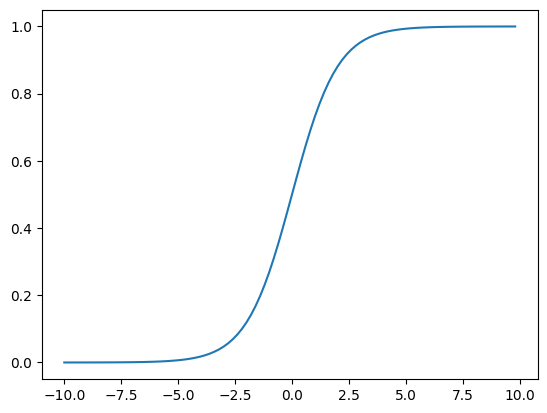

In [10]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

x = np.arange(-10, 10, 0.2)
y = sigmoid(x)
plt.plot(x, y)
plt.show()

这显然让人联想到，Sigmoid 函数非常适合用来当作神经网络中的激活函数，给整个模型引入非线性。

将激活函数并且加在线性计算之后，一并称之为“隐藏层”，这一改动使得神经网络模型理论上可以逼近任意的非线性模型。

### 前馈神经网络

前馈神经网络（Feedforward neural network）是一种最简单的人工神经网络（ANN），除了输入节点，每个节点都是一个带有非线性激活函数的神经元（或称处理单元），克服了感知器不能对线性不可分数据进行识别的弱点。这里我们需要提到一个术语 “多层感知机”（Multilayer perceptron, 简称 MLP），它的使用有些含糊不清：有的时候被模糊地认为是前馈神经网络的指代；有时严格指代由多层感知器（类似二分类阈值进行激活）所组成的网络。为了避免歧义，我们在本次教程中只使用 “前馈神经网络” 这种说法，但你应该知道 MLP 在具体的上下文中的指代。

我们现在就可以尝试写出一个糙版本的前馈神经网络，在 MNIST 数据集上进行测试：

In [11]:
import numpy as np
import megengine as mge
import megengine.functional as F
from megengine.data.dataset import MNIST
from megengine.data import SequentialSampler, RandomSampler, DataLoader
from megengine.autodiff import GradManager
import megengine.optimizer as optim

MNIST_DATA_PATH = "/data/datasets/MNIST/"  # 记得修改这里的路径

# 设置超参数
bs = 64
lr = 0.75
epochs = 5
num_hidden_1 = 256
num_hidden_2 = 128

# 读取原始数据集
train_dataset = MNIST(root=MNIST_DATA_PATH, train=True, download=False)
nums = len(train_dataset)
num_features = train_dataset[0][0].size
num_classes = 10

# 训练数据加载与预处理
train_sampler = SequentialSampler(dataset=train_dataset, batch_size=bs)
train_dataloader = DataLoader(dataset=train_dataset, sampler=train_sampler)

# 初始化参数，没有使用零初始化，而是用 NumPy 随机生成服从正态分布的数据，而且加入了缩放因子 Scale
W1 = mge.Parameter(np.random.normal(size=(num_features, num_hidden_1), scale=0.01))
b1 = mge.Parameter(np.random.normal(size=(num_hidden_1,), scale=0.01))
W2 = mge.Parameter(np.random.normal(size=(num_hidden_1, num_hidden_2), scale=0.01))
b2 = mge.Parameter(np.random.normal(size=(num_hidden_2,), scale=0.01))
W3 = mge.Parameter(np.random.normal(size=(num_hidden_2, num_classes), scale=0.01))
b3 = mge.Parameter(np.random.normal(size=(num_classes,), scale=0.01))

# 定义模型
def feedforward_neural_network(X):
    z1 = F.relu(F.matmul(X, W1) + b1)
    z2 = F.relu(F.matmul(z1, W2) + b2)
    z3 = F.matmul(z2, W3) + b3
    return z3

# 定义求导器和优化器
gm = GradManager().attach([W1, b1, W2, b2, W3, b3])
optimizer = optim.SGD([W1, b1, W2, b2, W3, b3], lr=lr)

# 模型训练
for epoch in range(epochs):
    total_loss = 0
    for batch_data, batch_label in train_dataloader:
        batch_data = F.flatten(mge.tensor(batch_data/255), 1).astype("float32")  # 注意这里进行了归一化
        batch_label = mge.tensor(batch_label)
        with gm:
            pred = feedforward_neural_network(batch_data)
            loss = F.loss.cross_entropy(pred, batch_label)
            gm.backward(loss)
        optimizer.step().clear_grad()
        total_loss +=  loss.item()
    print("epoch = {}, loss = {:.3f}".format(epoch, total_loss / len(train_dataloader)))

01 18:24:29 process the raw files of train set...
100%|████████████████████████████████| 60000/60000 [00:00<00:00, 1662712.85it/s]


epoch = 0, loss = 0.456
epoch = 1, loss = 0.124
epoch = 2, loss = 0.082
epoch = 3, loss = 0.066
epoch = 4, loss = 0.052


In [12]:
test_dataset = MNIST(root=MNIST_DATA_PATH, train=False, download=False)
test_sampler = RandomSampler(dataset=test_dataset, batch_size=100)
test_dataloader = DataLoader(dataset=test_dataset, sampler=test_sampler)

nums_correct = 0
for batch_data, batch_label in test_dataloader:
    batch_data = F.flatten(mge.tensor(batch_data/255), 1).astype("float32")   # 注意这里进行了归一化
    batch_label = mge.tensor(batch_label)
    logits = feedforward_neural_network(batch_data)
    pred = F.argmax(logits, axis=1)
    nums_correct += (pred == batch_label).sum().item()
print("Accuracy = {:.3f}".format(nums_correct / len(test_dataloader)))

01 18:24:45 process the raw files of test set...
100%|████████████████████████████████| 10000/10000 [00:00<00:00, 1584071.30it/s]


Accuracy = 96.090


我们欣喜地发现，经过 5 个周期的学习，我们的预测精度已经超过了单层的线性分类模型。

你可能已经注意到了一些细节（有一些相当关键！）：

- 我们目前设计的神经网络结构中均为全连接层，每层的参数量是非常大的，这会导致很大的计算和时间开销；
- 两个隐藏层的神经元个数也是需要人为设计的超参数，并且直接影响到整个网络模型的参数量；
- **我们的参数初始化选择了随机初始化而不是零初始化策略，** 这是为什么呢？
- 我们还对输入的数据进行了归一化处理，原始值位于 $(0, 255)$, 归一化后统一到 $(0,1)$;
- 我们选用的激活函数似乎并不是 Sigmoid, 而是一个叫做 ReLU 的家伙。

**请尝试修改各种超参数或网络的隐藏层数，看看会得到什么不同的结果。** 目前让我们暂时把这些疑惑缓存在脑海中。

### Recap: 请停下来看看这个

有了前面的理论和实践积累，现在是时候对神经网络的基本结构有更加直观而清晰的认知了。

我强烈推荐你看一看这个系列的视频作为阶段性的总结，绝对会受益匪浅：

- [3Blue1Brown 深度学习之神经网络的结构](https://www.bilibili.com/video/BV1bx411M7Zx) (对于当前教程而言，这个视频是必须观看的)
- [3Blue1Brown 深度学习之梯度下降法](https://www.bilibili.com/video/BV1Ux411j7ri)
- [3Blue1Brown 深度学习之直观理解反向传播](https://www.bilibili.com/video/BV16x411V7Qg?p=1)
- [3Blue1Brown 深度学习之反向传播的微积分原理](https://www.bilibili.com/video/BV16x411V7Qg?p=2)

完整看完第一个视频后，你应该能回答 “为什么要用 ReLU 代替 Sigmoid 作为激活函数” 这个问题了。

MegEngine 中实现了非常多常见的非线性激活函数，至于究竟选取哪一个激活函数，亦或是设计新的激活函数来使用，没有特别的规定。

## 更巧妙的计算图算子

我们在上一小节没有测试前馈神经网络在 CIFAR10 数据集上的效果，你可以自己修改代码测试一下，但预测精度恐怕仍不容乐观。究竟是哪个环节出问题了呢？

- 回顾一下计算图的基本结构，其中有数据节点和计算节点；
- 前馈神经网络的隐藏层设计可看作是对图结构的宏观调整，而作为参数的数据节点的初始化策略也可以被人为控制；
- 我们似乎忘记了计算节点对整个模型预测性能所带来的影响。

我们在处理 MNIST 图像的时候，使用了 Flatten 算子将一张图片中的像素展平成一个特征向量，这个处理方式一直保留到现在。

请你思考一下，对于一张由 R, G, B 颜色通道组成的图片，Flatten 操作是否能有效地将不同颜色通道中各个像素点的空间信息联系起来？

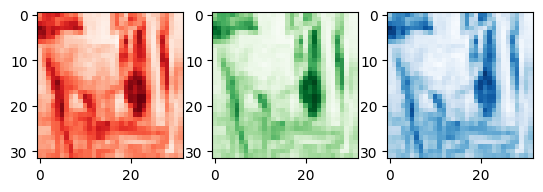

In [13]:
for channel_idx, color in enumerate(color_maps):
    plt.subplot(1, 3, channel_idx+1)
    plt.imshow(split_image[channel_idx], cmap=color)

plt.show()

### 从传统领域知识中学习

如今深度学习能够在很多领域大放异彩，离不开其与传统领域知识的结合，历史正启发着人们不断探索改进。

- 在数字图像处理领域（准确来说是数字信号处理领域），存在着一种名为 “卷积” （Convolution）的操作；
- 以下面的代码为例子，对于左边的原图，我们定义了两个 $3\times3$ 卷积核（Filter）对原图进行卷积运算；
- 可以理解成对于原图中的每个像素，都根据卷积核中给定的参数对周围九宫格的像素值进行加权求和，作为更新后的像素值。

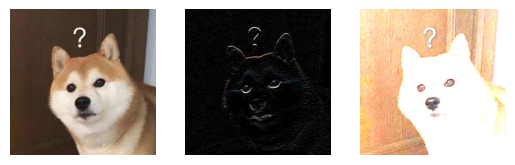

In [14]:
image = plt.imread("../../_static/images/chai.jpg")
plt.subplot(131)
plt.axis('off')
plt.imshow(image)

filter1 = np.array([[ -1, -2, -1],
                    [  0,  0,  0],
                    [  1,  2,  1]])
filter2 = np.array([[  0, -1,  0], 
                    [ -1,  8, -1],
                    [  0, -1,  0]])

res1 = cv2.filter2D(image, -1, filter1) # -1 表示自动计算卷积核深度，对于 RGB 图，卷积核会自动应用到 3 个通道
res2 = cv2.filter2D(image, -1, filter2) # 我们在进行 reshape 操作时经常也会用到 -1 来自动化计算

plt.subplot(132)
plt.axis('off')
plt.imshow(res1)
plt.subplot(133)
plt.axis('off')
plt.imshow(res2)
plt.show()

背后的细节我们暂时不用深究，直观上给人的感觉是：**卷积运算能够对原始图像的空间信息加以利用。**

这自然地启发我们在神经网络模型中定义一种卷积算子，来作为对图像特征的处理方式。

### 在 MegEngine 使用卷积计算

在 MegEngine 的 `funtional.nn` 模块中，实现了卷积相关的算子，我们以 `funtional.nn.conv2d` 为例子：

- 假设有一张 $5 \times 5$ 大小的 2D 单通道图像 `input_2d`, 像素值分别为 $0$ 到 $24$;
- 我们定义了 $3 \times 3$ 大小的卷积核 `filter_2d` 并应用在这张原始图像上，得到了输出图像 `output_2d` ;
- 从原始图像中 $6$ 至 $18$ 的像素，对应值都更新为其上下左右像素值之和（即原始值的 4 倍，对应 $24$ 到 $72$）。

In [15]:
input_2d = mge.tensor(np.arange(25).reshape(1, 1, 5, 5)).astype("float32")
filter_2d = mge.tensor(np.array([[0, 1, 0],
                                 [1, 0, 1],
                                 [0, 1, 0]]).reshape(1, 1, 3, 3)).astype("float32")
output_2d = F.nn.conv2d(input_2d, filter_2d)

print(input_2d.numpy())
print(output_2d.numpy())

[[[[ 0.  1.  2.  3.  4.]
   [ 5.  6.  7.  8.  9.]
   [10. 11. 12. 13. 14.]
   [15. 16. 17. 18. 19.]
   [20. 21. 22. 23. 24.]]]]
[[[[24. 28. 32.]
   [44. 48. 52.]
   [64. 68. 72.]]]]


相信你又有了新的疑惑——由于图像边缘的像素存在着 “没有邻居” 的情况，导致卷积计算后舍弃了这些原本位于边缘的像素点，直观来看图像的形状似乎 “小了一圈”，这个情况不是我们所希望的。处理办法是，在计算卷积操作时，先给边缘像素周围补上一圈像素（最常见的操作是补值为 0 的像素点），这样在进行卷积计算的时候，就能利用上原图中的所有像素信息了：

In [16]:
input_2d = mge.tensor(np.arange(25).reshape(1, 1, 5, 5)).astype("float32")
filter_2d = mge.tensor(np.array([[0, 1, 0],
                                 [1, 0, 1],
                                 [0, 1, 0]]).reshape(1, 1, 3, 3)).astype("float32")
output_2d = F.nn.conv2d(input_2d, filter_2d, padding=1)  # 注意这一行的变化，Padding = 1 意味着以 1 像素为宽度进行补 0

print(input_2d.numpy())
print(output_2d.numpy())

[[[[ 0.  1.  2.  3.  4.]
   [ 5.  6.  7.  8.  9.]
   [10. 11. 12. 13. 14.]
   [15. 16. 17. 18. 19.]
   [20. 21. 22. 23. 24.]]]]
[[[[ 6.  8. 11. 14. 12.]
   [16. 24. 28. 32. 26.]
   [31. 44. 48. 52. 41.]
   [46. 64. 68. 72. 56.]
   [36. 58. 61. 64. 42.]]]]


用到了卷积算子的神经网络又被人们称为 “卷积神经网络”（Convolutional Neural Network, CNN），从结构上看，它也是前馈神经网络的一种。卷积神经网络常用于计算机视觉领域，上面的 `padding` 操作也是计算机视觉中常见的图像预处理手段，不过我们的教程目前还不打算涉及到太多关于计算机视觉相关的内容，因此不打算进行更多这方面的解释。我们需要关注的是：

- 相较于简单粗暴的 `flatten` 操作， `conv` 操作更能够利用图像的空间局部信息；
- 卷积核中的参数其实和全连接层中的参数类似，都是 “可学习的” ，这意味着我们可以使用深度学习框架来优化卷积神经网络模型；
- 但与卷积有关的算子，需要在计算的过程中保证输入输出数据维度/形状变化的一致性，否则会出错。

## 使用卷积神经网络对 CIFAR10 进行分类

结合前面提到的知识，现在我们将构建一个多层的卷积神经网络模型！

- 由于 MegEngine 默认 Tensor 的数据排布是 $(N,C,H,W)$ 格式，而我们的 CIFAR10 数据集图片是 $(N,H,W,C)$ 格式，所以我们在下面的代码中进行了一些数据预处理；
- 在 `megengine.data.transform` 中实现了一些常见的预处理操作，比如旋转、平移、翻转等等，当然也包括数据格式的转换；
- 在进行数据格式转换的同时，我们也使用 `Normalize` 对数据进行了归一化操作，至于为什么这样做，我们以后会进行解释。

In [18]:
import numpy as np
import megengine as mge
import megengine.functional as F
import megengine.module as M
from megengine.data.dataset import CIFAR10
from megengine.data.transform import ToMode, Normalize, Compose
from megengine.data import SequentialSampler, RandomSampler, DataLoader
from megengine.autodiff import GradManager
import megengine.optimizer as optim

CIFAR10_DATA_PATH = "/data/datasets/CIFAR10/"  # 记得修改这里的路径

# 设置超参数
bs = 64
lr = 0.005
epochs = 20

# 读取原始数据集
train_dataset = CIFAR10(root=CIFAR10_DATA_PATH, train=True, download=False)
num_classes = 10

# 训练数据加载与预处理
transform = Compose([
    Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    ToMode('CHW'),
])
train_sampler = SequentialSampler(dataset=train_dataset, batch_size=bs)
train_dataloader = DataLoader(train_dataset, train_sampler, transform)

# 初始化参数
conv1_weight = mge.Parameter(np.random.normal(size=(6, 3, 5, 5), scale=0.01))
conv1_bias = mge.Parameter(np.random.normal(size=(1, 6, 1, 1), scale=0.01))
conv2_weight = mge.Parameter(np.random.normal(size=(16, 6, 5, 5), scale=0.01))
conv2_bias = mge.Parameter(np.random.normal(size=(1, 16, 1, 1), scale=0.01))
linear1_weight = mge.Parameter(np.random.normal(size=(120, 16 * 5 * 5), scale=0.01))
linear1_bias = mge.Parameter(np.random.normal(size=(120,), scale=0.01))
linear2_weight = mge.Parameter(np.random.normal(size=(84, 120), scale=0.01))
linear2_bias = mge.Parameter(np.random.normal(size=(84,)))
linear3_weight = mge.Parameter(np.random.normal(size=(10, 84), scale=0.01))
linear3_bias = mge.Parameter(np.random.normal(size=(10,), scale=0.01))

param_group = [conv1_weight, conv1_bias,
               conv2_weight, conv2_bias,
               linear1_weight, linear1_bias,
               linear2_weight, linear2_bias,
               linear3_weight, linear3_bias]

# 定义模型
def cnn_model(x):                                  # (3, 32, 32)
    x = F.conv2d(x, conv1_weight, conv1_bias)      # (6, 28, 28)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)                         # (6, 14, 14)
    x = F.conv2d(x, conv2_weight, conv2_bias)      # (16, 10, 10)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)                         # (16, 5, 5)
    x = F.flatten(x, 1)                            # (16 * 5 * 5, 1)
    x = F.linear(x, linear1_weight, linear1_bias)  # (120, 1)
    x = F.relu(x)
    x = F.linear(x, linear2_weight, linear2_bias)  # (84, 1)
    x = F.relu(x)
    x = F.linear(x, linear3_weight, linear3_bias)  # (10, 1)
    return x
    
# 定义求导器和优化器
gm = GradManager().attach(param_group)
optimizer = optim.SGD(param_group, lr)

# 模型训练
for epoch in range(epochs):
    total_loss = 0
    for batch_data, batch_label in train_dataloader:
        batch_data = mge.tensor(batch_data).astype("float32")
        batch_label = mge.tensor(batch_label)
        with gm:
            pred = cnn_model(batch_data)
            loss = F.loss.cross_entropy(pred, batch_label)
            gm.backward(loss)
        optimizer.step().clear_grad()
        total_loss += loss.item()
    print("epoch = {}, loss = {:.3f}".format(epoch, total_loss / len(train_dataloader)))

epoch = 0, loss = 2.243
epoch = 1, loss = 1.942
epoch = 2, loss = 1.688
epoch = 3, loss = 1.527
epoch = 4, loss = 1.431
epoch = 5, loss = 1.362
epoch = 6, loss = 1.302
epoch = 7, loss = 1.249
epoch = 8, loss = 1.202
epoch = 9, loss = 1.159
epoch = 10, loss = 1.119
epoch = 11, loss = 1.086
epoch = 12, loss = 1.050
epoch = 13, loss = 1.017
epoch = 14, loss = 0.989
epoch = 15, loss = 0.962
epoch = 16, loss = 0.937
epoch = 17, loss = 0.911
epoch = 18, loss = 0.888
epoch = 19, loss = 0.867


In [19]:
test_dataset = CIFAR10(root=CIFAR10_DATA_PATH, train=False, download=False)
test_sampler = RandomSampler(dataset=test_dataset, batch_size=100)
test_dataloader = DataLoader(test_dataset, test_sampler, transform)

nums_correct = 0
for batch_data, batch_label in test_dataloader:
    batch_data = mge.tensor(batch_data).astype("float32")
    batch_label = mge.tensor(batch_label)
    logits = cnn_model(batch_data)
    pred = F.argmax(logits, axis=1)
    nums_correct += (pred == batch_label).sum().item()
print("Accuracy = {:.3f}".format(nums_correct / len(test_dataloader)))

Accuracy = 54.350


可以看到，经过 20 个周期的训练，模型在 CIFAR10 图片分类上已经能够达到超过 50% 的预测准确率。

## 总结回顾

基于线性模型的局限性，我们从不同的角度出发尝试对模型进行了改进，最终取得了不错的效果：

- 模型结构变得更加复杂，由单层变成多层，为了解决非线性可分问题，我们引入了激活函数这一概念，最终认识了什么是前馈神经网络；
- 模型算子变得更加精妙，我们借助对传统计算机视觉领域的卷积操作的了解，将隐藏层由简单的全连接层升级成卷积层，卷积神经网络便诞生了。

我们也了解到了数字图像处理方面的一些知识，感兴趣的同学可以选择将计算机视觉作为自己接下来的研究方向。

接下来请在脑中尝试构建出一张完整的计算图（如果你还没看过前面提到的 3Blue1brown 的视频，现在去看看吧）：

- 我们将数据集中的样本经过处理后变为 Tensor 格式，每个样本作为输入层的各个神经节点，开始在图中流动；
- 在隐藏层中有着许许多多的计算节点，连接着不同节点之间的是需要被学习和优化的参数，也被叫做权重；
- 前向传播往往会经历特征提取和计算的过程，最终我们会根据任务类型来设计一个损失函数，用来评估训练过程中的模型表现；
- 反向传播就好像一层层的浪花，根据链式法则去一层一层地计算当前层梯度，然后更新参数，又将梯度信息传给下一层...

## 问题思考

CIFAR10 图片分类任务的准确率还有很大的提升空间，是不是意味着只要不断加大模型的深度，加上精细的超参数调整，就总是能够取得更好的效果呢？

如果你尝试自己实现过上面的几个模型，调整过超参数，可能会遇到如下一些情况：

- 我的 Loss 在训练几个 epoch 之后就不下降了，有时甚至从来没有下降过！
- 我的 Loss 从第一个 epoch 开始就显示为 NaN, 发生什么事了？

恭喜你 🎉 ，你开始接触到深度学习炼丹师再熟悉不过的一些 “玄学” 现象，如果能分析出问题背后可能的原因，将很有成就感（分析不出的话也不用气馁）。

到目前为止，我们一直都在使用 MegEngine 的 `functional` 模块中的算子来定义我们的模型，一些问题已经初见端倪：

- **当模型结构开始变得越来越复杂，网络中参数的定义和初始化代码写起来很不方便。** 
- **如果出现重复的模型结构，现在的这种定义方式十分低效且丑陋。**

深度学习框架已经为用户简化了梯度的自动求导和参数优化等流程，自然也可以提供一种更加方便的模式来定义我们的模型。我们在接下来的教程中，除了要和你讨论如何使用 MegEngine 中的 `module` 模块写出更加优雅的模型之外，还会和你分享一些神经网络模型训练中的常见技巧。深度学习，简单开发。我们鼓励你在实践中不断思考，并启发自己去探索直觉性或理论性的解释。

## 
